# Imports

In [3]:
#!pip install -q tensorflow==2.0.0
#!pip install category_encoders

#Helpers
import math
import warnings
from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split
#Data manipulating
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
# Deep Learning and Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#Algoritmos
#ARIMAX
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt
from sklearn.pipeline import Pipeline
#Data Transform
#from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


# Data Load & Describe

In [0]:
# Get the DataSet
df = pd.read_csv('notas.csv')
# Tratamento dos dados
df['data'] = pd.to_datetime(df["data"])
df.index = df['data']

In [0]:
# Prepara o DataFrame do futuro
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,365*3)] # Ver 3 anos para frente
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_df['data'] = pd.to_datetime(future_df.index)
future_df['ano']  = future_df.data.dt.year
future_df['dia']  = future_df.data.dt.day
future_df['mes']  = future_df.data.dt.month
future_df['dia_semana'] = future_df.data.dt.weekday
future_df['itens'] = df.itens.median()

#### Descrição dos dados

In [6]:
#Tipos de dados
print(df.dtypes)

data          datetime64[ns]
count                  int64
itens                  int64
ano                    int64
mes                    int64
dia                    int64
dia_semana             int64
dtype: object


In [8]:
df.tail()

,data,count,itens,ano,mes,dia,dia_semana
data,,,,,,,
2020-02-19,2020-02-19,37,34,2020,2,19,4
2020-02-20,2020-02-20,13,21,2020,2,20,5
2020-02-21,2020-02-21,13,12,2020,2,21,6
2020-02-22,2020-02-22,20,19,2020,2,22,7
2020-02-24,2020-02-24,4,4,2020,2,24,2


In [9]:
df.describe()

,count,itens,ano,mes,dia,dia_semana
count,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000
mean,22.498684,24.836842,2017.157237,6.451974,15.770395,4.480263
std,21.882895,24.202861,1.457184,3.541952,8.749490,1.751029
min,1.000000,-5.000000,2015.000000,1.000000,1.000000,1.000000
25%,9.000000,10.000000,2016.000000,3.000000,8.000000,3.000000
50%,17.000000,19.000000,2017.000000,6.000000,16.000000,4.000000
75%,29.000000,32.000000,2018.000000,10.000000,23.000000,6.000000
max,280.000000,264.000000,2020.000000,12.000000,31.000000,7.000000


In [89]:
df.head()

,data,count,itens,ano,mes,dia,dia_semana
data,,,,,,,
2015-01-05,2015-01-05,1,1,2015,1,5,2
2015-01-07,2015-01-07,1,1,2015,1,7,4
2015-01-08,2015-01-08,1,1,2015,1,8,5
2015-01-09,2015-01-09,1,1,2015,1,9,6
2015-01-16,2015-01-16,4,4,2015,1,16,6


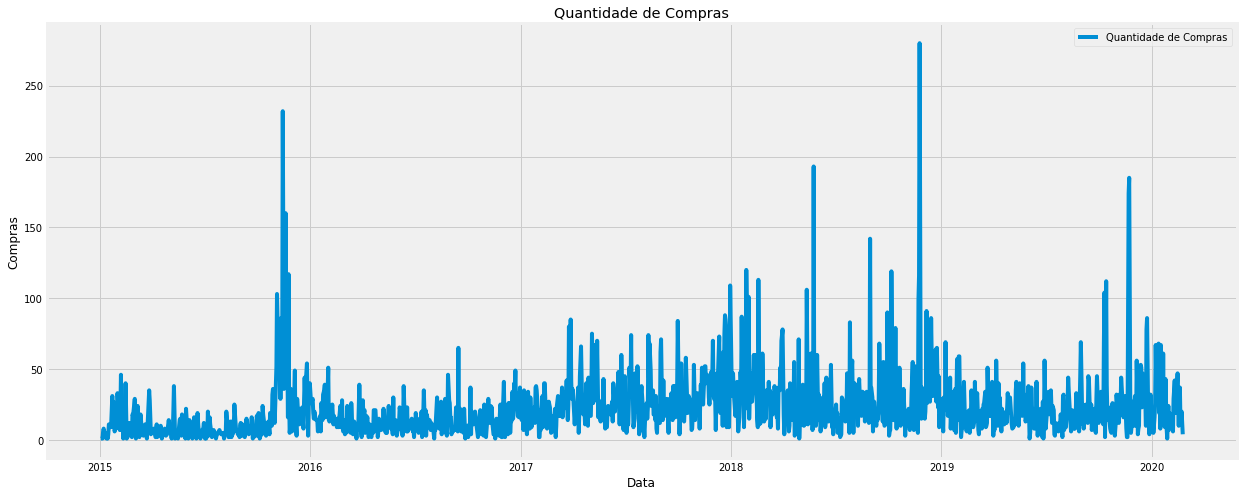

In [7]:
#PLotar o Grafico
fig, ax = plt.subplots()
ax.figure.set_size_inches(19,8)
#print(X_train.reshape(1,95))
plt.title('Quantidade de Compras')
plt.ylabel("Compras")
plt.xlabel("Data")
ax.plot(df.index,df['count'],label='Quantidade de Compras')
ax.legend()
plt.show()

# Data Cleaning e Transform

In [0]:
train_data = df.drop(columns=['data'])[:'2019-04-01']
test_data = df.drop(columns=['data'])['2019-04-01':]

X_columns = ['dia','ano','mes','dia_semana']

X_train = train_data[X_columns]
y_train = train_data[['count']]

X_test = test_data[X_columns]
y_test= test_data[['count']]


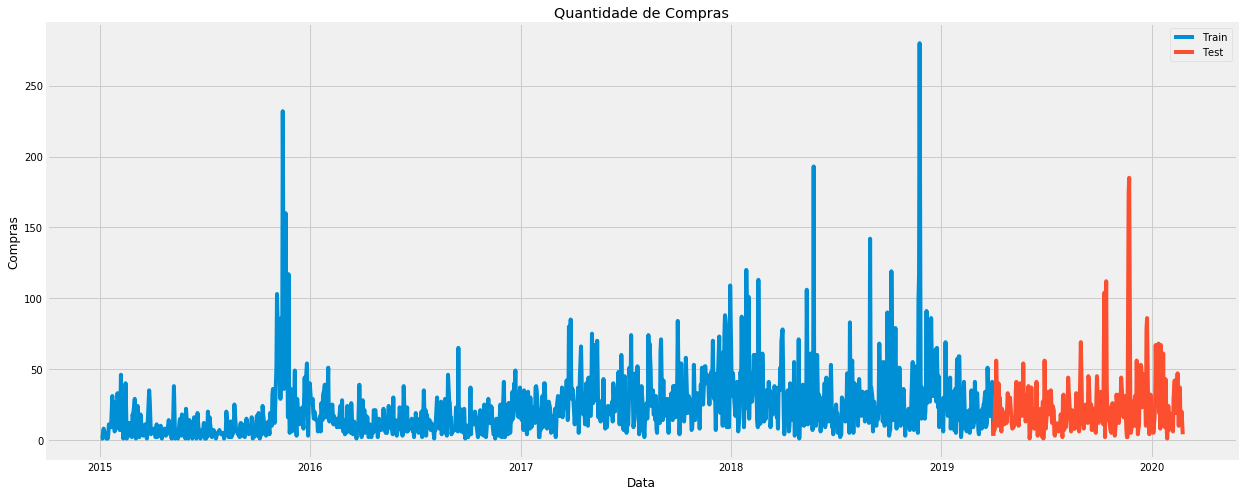

In [85]:
#PLotar o Grafico de treino e teste
fig, ax = plt.subplots()
ax.figure.set_size_inches(19,8)
plt.title('Quantidade de Compras')
plt.ylabel("Compras")
plt.xlabel("Data")
ax.plot(X_train.index,y_train['count'],label='Train')
ax.plot(X_test.index,y_test['count'],label='Test')
ax.legend()
plt.show()

In [34]:
print(len(X_test),len(y_test))

276 276


### Reescalar os dados

In [0]:
#Rescalar os dados
scalerTrain = StandardScaler()
scalerTest = StandardScaler()

X_train = scalerTrain.fit_transform(X_train)
X_test= scalerTest.fit_transform(X_test)

# Transformar novamente em pd
X_train_scaled = pd.DataFrame(X_train, index=train_data.index, columns=X_columns)
X_test_scaled = pd.DataFrame(X_test, index=test_data.index, columns=X_columns)


# Feature Selection (sem uso)

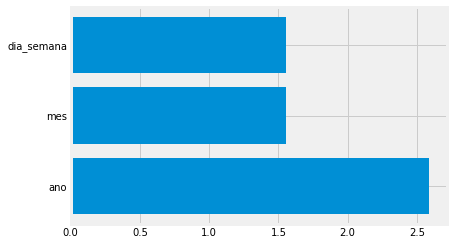

In [0]:
from sklearn.feature_selection import SelectKBest # Melhor para dados categoricos e features numericas
from sklearn.feature_selection import chi2 # Categoricos
from sklearn.feature_selection import RFE #TODO # Bom para regressoes

bestfeatures = SelectKBest( k=2)
fit = bestfeatures.fit(df[X_columns],df['count'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(3,'Score') #print X best features

plt.barh(width=featureScores.nlargest(3,'Score').Score,y=featureScores.nlargest(3,'Score').Specs)
best_columns = featureScores.nlargest(2,'Score').Specs.values

# Treino com LSTM

In [90]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7 #numero de dias que olha pra ras

#Gera dados de treino e teste
X_train_lstm, y_train_lstm = create_dataset(X_train_scaled,y_train, time_steps)
X_test_lstm, y_test_lstm = create_dataset(X_test_scaled,y_test, time_steps)

print(X_train_lstm.shape, y_train_lstm.shape)
print(X_test_lstm.shape, y_test.shape)

(1238, 7, 3) (1238, 1)
(269, 7, 3) (276, 1)


In [0]:
from IPython.display import clear_output
#Melhores parametros ate agora
#Time steps = 7
epochs = 1060
batch_size = 32
loss='mae'
optimizer='adam'
dropout = 0.1
#neurons = 100, 100
#Train Score: 0.41 MSE (0.64 RMSE)
#Test Score: 11.97 MSE (3.46 RMSE)

model = keras.Sequential()
#model.add(keras.layers.LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(keras.layers.Dropout(dropout))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(1))
model.compile(loss=loss,optimizer=optimizer)
#model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False,)
#epoch_hist = []
#for epoch in range(epochs):
#  print(epoch,' de ', epochs)
#  result = model.fit(X_train_lstm, y_train_lstm,batch_size,shuffle=False,verbose=0)
#  epoch_hist.append(result.history["loss"][0])
#  print('loss',result.history['loss'] )
#  clear_output(wait=True)
#  plt.plot(epoch_hist)
#  plt.show()




In [0]:
#Treina o modelo (quantas vezes quiser)
model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False,)

In [0]:
epoch_hist = []
%matplotlib inline
for epoch in range(epochs):
  print(epoch,' de ', epochs)
  result = model.fit(X_train_lstm, y_train_lstm,batch_size=batch_size,shuffle=False,verbose=0)
  epoch_hist.append(result.history["loss"][0])
  print('loss',result.history['loss'] )
  clear_output(wait=True)
  plt.plot(epoch_hist)
  plt.show()

In [104]:
# Estimate model performance
trainScore = model.evaluate(X_train_lstm, y_train_lstm, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 5.57 MSE (2.36 RMSE)
Test Score: 15.04 MSE (3.88 RMSE)


In [0]:
#Save or load model weights or complete model
#model.load_weights('notas_wv2.h5')
#model.save_weights('notas_wv_4.h5')
#model.save('notas_m_4.h5')

In [0]:
#Prever e criar os dataframes
prediction = model.predict(X_test_lstm)
prediction_lstm_df = pd.DataFrame(prediction,index=y_test[:len(prediction)].index,columns=y_test.columns)
future_df_lstm_scaled = pd.DataFrame(scalerTest.transform(future_df[X_columns]),index=future_df.index,columns=X_columns)
X_forward_lstm, teste2 = create_dataset(future_df_lstm_scaled,future_df_lstm_scaled[['dia']], time_steps)
future_df_lstm_prediction = pd.DataFrame(model.predict(X_forward_lstm),index=future_df_lstm_scaled[:len(X_forward_lstm)].index,columns=y_test.columns)

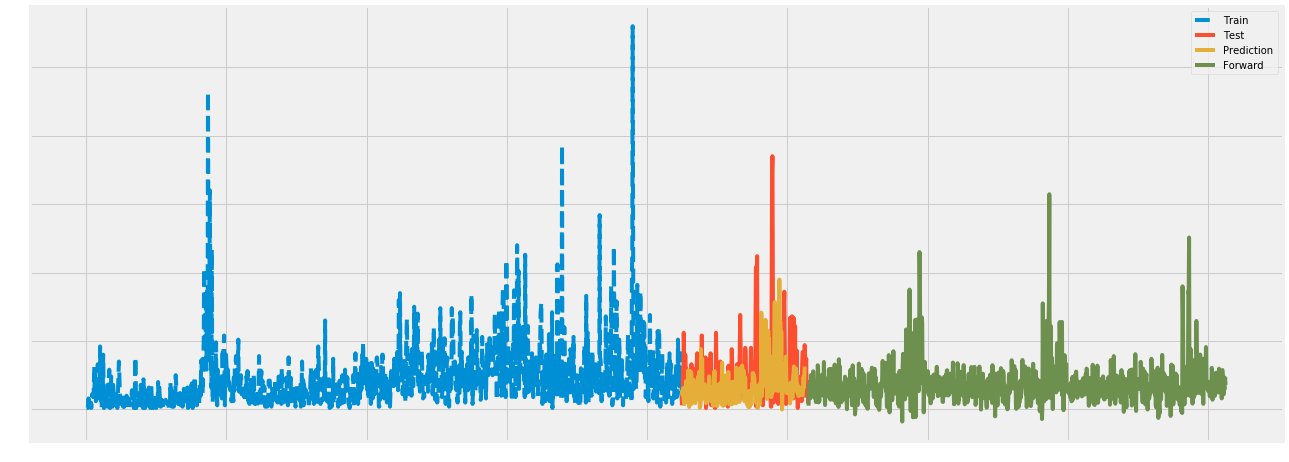

In [106]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,8)
#print(X_train.reshape(1,95))
ax.plot(y_train,label='Train',linestyle='--')
ax.plot(y_test,label='Test')
ax.plot(prediction_lstm_df,label='Prediction')
ax.plot(future_df_lstm_prediction,label='Forward')
ax.tick_params(axis='both', colors='white')
ax.legend()
plt.show()
